# Albumentations Tutorial

In [15]:
import cv2 
import albumentations as A 
import numpy as np 
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patces 
import random

In [2]:
# utils.py
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    '''Visualize a single bounding box on the image'''
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img


def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5

    for i in range(1, len(images)):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name='Elon')
        else:
            img = images[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

In [3]:
from PIL import Image

### 1. For classification

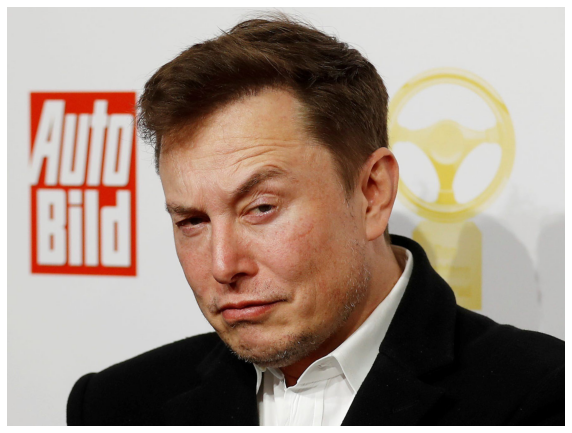

In [4]:
image = Image.open(r'dataset\albumentations_data\images\elon.jpeg')

visualize(image)

In [5]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
])

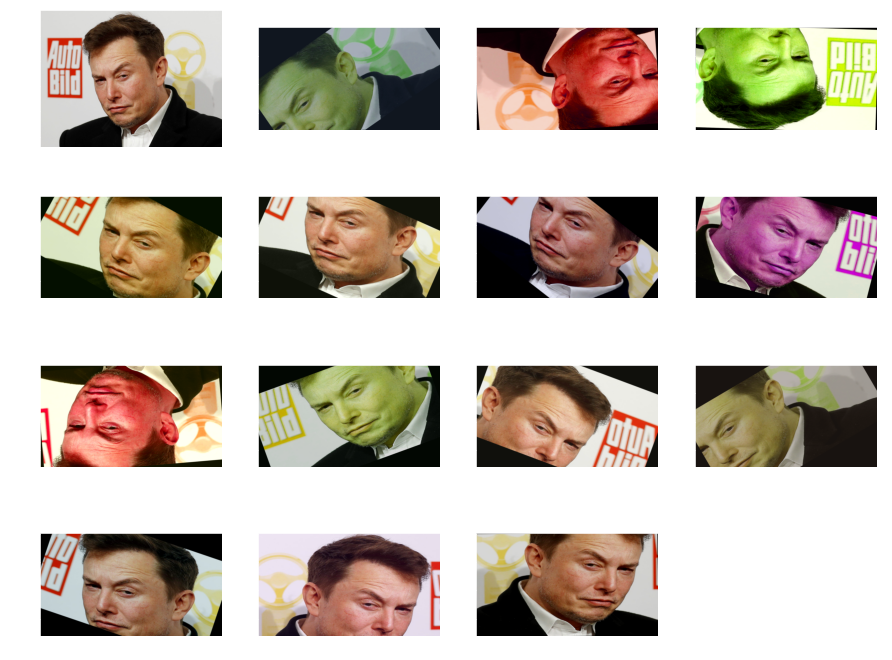

In [6]:
images_list = [image]
image = np.array(image)
for i in range(15):
    augmentations = transform(image=image)
    augmented_img = augmentations["image"]
    images_list.append(augmented_img)
plot_examples(images_list)

### 2. For Segmentation

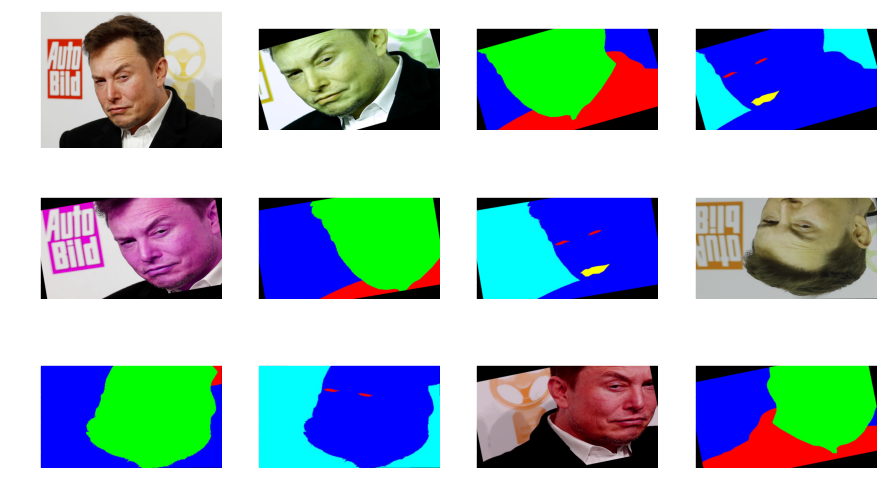

In [8]:
images_list = [image]
image = np.array(image)
mask = Image.open(r"E:\Learn_something\Pytorch_Getting_start\dataset\albumentations_data\images\mask.jpeg")
mask = np.array(mask) # np.asarray*(mask), np.array(mask)
mask2 = Image.open(r"E:\Learn_something\Pytorch_Getting_start\dataset\albumentations_data\images\second_mask.jpeg")
mask2 = np.array(mask2)
for i in range(4):
    # augmentations = transform(image=image, mask=mask)
    augmentations = transform(image=image, masks=[mask, mask2])
    augmented_img = augmentations["image"]
    # augmented_mask = augmentations["mask"]
    augmented_masks = augmentations["masks"]
    images_list.append(augmented_img)
    # images_list.append(augmented_mask)
    images_list.append(augmented_masks[0])
    images_list.append(augmented_masks[1])
plot_examples(images_list)

### 3. For detection

In [29]:
image_dt = cv2.imread(r'dataset\albumentations_data\images\cat.jpg')
image_dt = cv2.cvtColor(image_dt, cv2.COLOR_BGR2RGB)
bboxes = [[13, 170, 224, 410]]

# different bounding boxes format
# Pascal_voc (x_min, y_min, x_max, y_max), YOLO, COCO...

In [31]:
transform_dt = A.Compose(
    [
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    ], bbox_params=A.BboxParams(format="pascal_voc", min_area=2048,
                                min_visibility=0.3, label_fields=[])
)

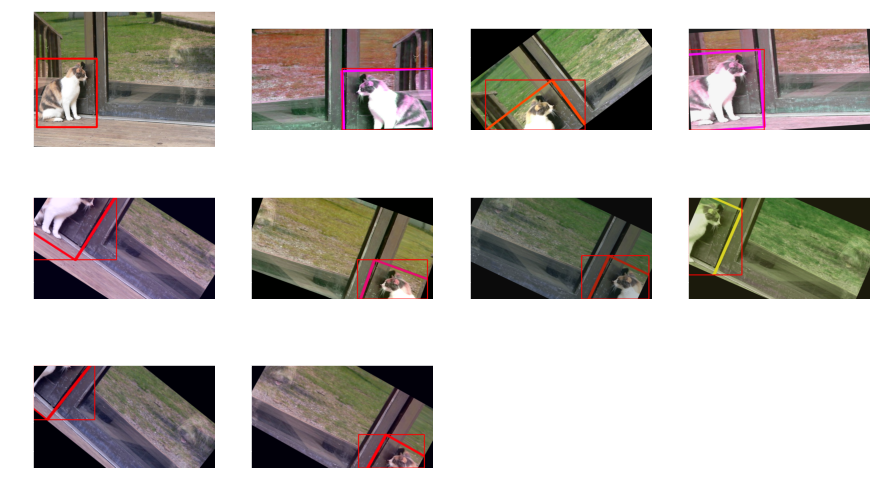

In [34]:
images_list_dt = [image_dt]
saved_bboxes = [bboxes[0]]
for i in range(15):
    augmentations = transform_dt(image=image_dt, bboxes=bboxes)
    augmented_img = augmentations["image"]

    if len(augmentations["bboxes"]) == 0:
        continue
    images_list_dt.append(augmented_img)
    saved_bboxes.append(augmentations["bboxes"][0])

plot_examples(images_list_dt, saved_bboxes)

## 4. Full Pytorch Example

In [36]:
import torch.nn as nn 
from albumentations.pytorch import ToTensorV2
import os

In [43]:
class ImageFolder(nn.Module):
    def __init__(self, root_dir, transform=None):
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
        
        return image, label

In [38]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255
    ),
    ToTensorV2()
])

In [47]:
dataset = ImageFolder(root_dir = r'dataset\albumentations_data\cat_dogs',
                      transform=transform)

# for x, y in dataset:
#     print(x.shape)
#     # print(y.shape)
dataset.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'data': [('cat.0.jpg', 0),
  ('cat.1.jpg', 0),
  ('cat.2.jpg', 0),
  ('cat.3.jpg', 0),
  ('cat.4.jpg', 0),
  ('cat.5.jpg', 0),
  ('cat.6.jpg', 0),
  ('cat.7.jpg', 0),
  ('dog.0.jpg', 0),
  ('n123686.jpg', 1),
  ('n123687.jpg', 1),
  ('n123688.jpg', 1),
  ('n123689.jpg', 1),
  ('n123690.jpg', 1),
  ('n123691.jpg', 1),
  ('n123692.jpg', 1),
  ('n123693.jpg', 1),
  ('n123694.jpg', 1),
  ('n123695.jpg', 1)],
 'root_dir': 'dataset\\albumentations_data\\cat_dogs',
 'transform': Compose([
   Resize(always_apply=False, p=1, height=1080, width=1920, interpolation=1),
   RandomCrop(always_apply=False, p=1.0, height=720, width=1280),
